# Project Description

References:
- https://www.kaggle.com/c/finunichamp2018-1/data

Для 24 511 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также страховая стоимость транспортного средства (файл insvalue_train.csv).

Требуется построить модель, предсказывающую страховую стоимость транспортного средства клиента (признак target) для 3662 договоров из тестового набора данных (файл insvalue_test.csv).

Метрикой качества является средняя относительная ошибка предсказания (Mean Absolute Percentage Error). Чем меньше значение MAPE, тем лучше результат.

$$MAPE = \frac{1}{n} \sum_{i=1}^n{\frac{|\hat{y_i}-y_i|}{y_i}} \times 100\%.$$

Одной из особенностей данной задачи является то, что почти для всех марок присутствуют разные модели, представляющие их.

Описание полей
- column_1 - пол водителя;
- column_2 - стаж вождения;
- column_3 - семейное положение водителя;
- column_4 - город регистрации водителя;
- column_5 - город регистрации договора;
- column_6 - максимальная просрочка по выплатам;
- column_7 - тип двигателя пробег транспортного средства;
- column_8 - пробег транспортного средства;
- column_9 - год производства транспортного средства;
- column_10 - мощность двигателя в лошадиных силах;
- column_11 - количество договоров клиента;
- column_12 - количество договоров транспортного средства;
- column_13 - возраст клиента;
- column_14 - тип транспортного средства;
- column_15 - страна-производитель транспортного средства;
- column_16 - наличие телематических систем, установленных на транспортное средство;
- column_17 - марка и модель автомобиля (задача усложняется тем, что в выборке почти для всех марок присутствуют разные модели, представляющие их, т.е. марка X в выборке представлена моделями x1,x2, хотя в явном виде эта информация в данных не присутствует);
- column_18 - технический параметр транспортного средства.
В тестовом наборе данных каждому договору соответствует уникальный идентификатор id.

# Initialization

In [1]:
import datetime as dt

import re

import logging
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import stats
import sklearn as sk
import pickle

import statsmodels.api as sm

# create the logger and set the logging level
logger = logging.getLogger('main')

if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.handlers[-1].setFormatter(logging.Formatter(fmt='%(asctime)s - %(levelname)s - %(message)s',
                                                   datefmt='%Y-%m-%d %H:%M:%S'))
logger.setLevel(logging.DEBUG)

plt.style.use('seaborn')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.figsize'] = [8, 5]
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Loading Data

In [3]:
df_train_original = pd.read_csv('insvalue_train.csv', sep=',')

df_test_original  = pd.read_csv('insvalue_test.csv', index_col='id', sep=',')
df_test_original['target'] = np.nan

In [4]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24511 entries, 0 to 24510
Data columns (total 19 columns):
column_1     24511 non-null int64
column_2     24425 non-null float64
column_3     24511 non-null object
column_4     24511 non-null object
column_5     24511 non-null object
column_6     24511 non-null float64
column_7     24511 non-null object
column_8     24511 non-null float64
column_9     24511 non-null int64
column_10    24511 non-null float64
column_11    24511 non-null int64
column_12    24511 non-null int64
column_13    24511 non-null float64
column_14    24511 non-null int64
column_15    24511 non-null object
column_16    24511 non-null int64
column_17    24511 non-null object
column_18    24511 non-null float64
target       24511 non-null float64
dtypes: float64(7), int64(6), object(6)
memory usage: 3.6+ MB


In [5]:
df_train_original.head(5)

,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,target
0,2,15.07,a1,b0,b0,53.00,q2,1.00,2,249.00,23,1,58.03,1,c4,1,k,3.10,"3,105,287.61"
1,1,12.20,a3,b0,b0,6.00,q1,"2,100.00",4,123.00,4,3,81.55,1,c0,0,a,1.67,"375,255.68"
2,2,50.34,a1,b4,b4,10.16,q1,1.00,2,181.00,9,0,76.69,1,c3,1,j,4.27,"991,012.34"
3,1,20.73,a1,b86,b0,0.00,q2,"60,000.00",7,211.00,29,0,79.13,1,c4,0,f,5.20,"938,984.99"
4,2,51.63,a1,b0,b0,37.00,q1,"48,065.00",7,209.00,19,0,81.55,1,c1,0,h,6.14,"776,107.46"


In [6]:
# renaming and reordering columns to get more sensible look
col_renaming_map = \
    {
     # driver's characteristics
     'column_1':  'sex', 
     'column_13': 'age',      # client age
     'column_3':  'ms',       # marital status
     'column_2':  'de',       # driving experience
     'column_4':  'drc',      # city the driver is registered in (the residency)
     'column_5':  'crc',      # city the contract is registered in
     'column_11': 'tic',      # number of total ins. contracts
     'column_12': 'cic',      # number of car insurance contracts
     'column_6':  'overdue_max', # an indicator of financial maturity
     # car's characteristics
     'column_17': 'cmm',      # car maker and car model
     'column_15': 'co',       # country of origin
     'column_9':  'my',       # manufacturing year
     'column_14': 'vt',       # veehicle type
     'column_7':  'et',       # engine type
     'column_10': 'hp',       # horse power
     'column_8':  'mi',       # mileage 
     'column_16': 'bb',       # presence of the black box
     'column_18': 'tp'        # some technical parameter of car
    }
    
col_order_list = [
    # driver's characteristics
    'sex', 'age', 'ms', 'de', 'drc', 
    # contracts
    'crc', 'tic', 'cic', 'overdue_max',
    # car's characteristics
    'cmm', 'co', 'my', 'vt', 'et', 'hp', 'mi', 'bb', 'tp',
    'target']
     
df_train = df_train_original.rename(columns=col_renaming_map).reindex(columns=col_order_list)
assert df_train.shape[1] == df_train_original.shape[1]
print(df_train.shape)

df_test  = df_test_original.rename(columns=col_renaming_map).reindex(columns=col_order_list)
assert df_test.shape[1] == df_test_original.shape[1]
print(df_test.shape)

(24511, 19)
(3662, 19)


In [7]:
# correcting the data type for categorical data
for col_name in ['sex', 'ms', 'drc', 'crc', 'et', 'vt', 'co', 'cmm']:
    df_train[col_name] = df_train[col_name].astype('category')
    df_test[col_name]  = df_test[col_name].astype('category')
    # copying the full set of categories as this will be required by pasty later
    df_test[col_name]  = df_test[col_name].cat.set_categories(df_train[col_name].cat.categories)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24511 entries, 0 to 24510
Data columns (total 19 columns):
sex            24511 non-null category
age            24511 non-null float64
ms             24511 non-null category
de             24425 non-null float64
drc            24511 non-null category
crc            24511 non-null category
tic            24511 non-null int64
cic            24511 non-null int64
overdue_max    24511 non-null float64
cmm            24511 non-null category
co             24511 non-null category
my             24511 non-null int64
vt             24511 non-null category
et             24511 non-null category
hp             24511 non-null float64
mi             24511 non-null float64
bb             24511 non-null int64
tp             24511 non-null float64
target         24511 non-null float64
dtypes: category(8), float64(7), int64(4)
memory usage: 2.4 MB


In [8]:
df_train.head(5)

,sex,age,ms,de,drc,crc,tic,cic,overdue_max,cmm,co,my,vt,et,hp,mi,bb,tp,target
0,2,58.03,a1,15.07,b0,b0,23,1,53.00,k,c4,2,1,q2,249.00,1.00,1,3.10,"3,105,287.61"
1,1,81.55,a3,12.20,b0,b0,4,3,6.00,a,c0,4,1,q1,123.00,"2,100.00",0,1.67,"375,255.68"
2,2,76.69,a1,50.34,b4,b4,9,0,10.16,j,c3,2,1,q1,181.00,1.00,1,4.27,"991,012.34"
3,1,79.13,a1,20.73,b86,b0,29,0,0.00,f,c4,7,1,q2,211.00,"60,000.00",0,5.20,"938,984.99"
4,2,81.55,a1,51.63,b0,b0,19,0,37.00,h,c1,7,1,q1,209.00,"48,065.00",0,6.14,"776,107.46"


# Normalizing Data

## Description

In [9]:
df_train.describe()

,age,de,tic,cic,overdue_max,my,hp,mi,bb,tp,target
count,"24,511.00","24,425.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00"
mean,62.46,23.37,15.03,1.16,26.02,5.16,179.65,"29,149.38",0.09,4.01,"859,848.79"
std,14.20,12.83,14.12,1.63,28.65,1.58,60.97,"30,282.59",0.28,2.04,"620,097.89"
min,26.31,0.00,0.00,0.00,0.00,1.00,77.00,0.00,0.00,-0.59,"231,853.40"
25%,51.63,13.64,6.00,0.00,5.00,4.00,140.00,"5,000.00",0.00,2.24,"435,176.37"
50%,60.56,20.73,11.00,1.00,20.61,5.00,173.00,"21,000.00",0.00,4.02,"678,556.83"
75%,73.01,29.06,20.00,2.00,40.00,6.00,211.00,"44,000.00",0.00,5.78,"1,075,319.86"
max,113.29,82.76,239.00,22.00,824.00,11.00,"1,984.00","472,000.00",1.00,8.66,"4,833,195.20"


In [11]:
df_test.describe()

,age,de,tic,cic,overdue_max,my,hp,mi,bb,tp,target
count,"3,662.00","3,653.00","3,662.00","3,662.00","3,662.00","3,662.00","3,662.00","3,659.00","3,662.00","3,662.00",0.00
mean,62.15,23.20,15.08,1.13,25.22,5.17,181.61,"28,811.15",0.09,3.98,nan
std,14.31,12.93,13.88,1.63,30.01,1.60,66.88,"30,352.90",0.29,2.03,nan
min,27.68,0.00,0.00,0.00,0.00,1.00,75.00,0.00,0.00,-0.05,nan
25%,50.34,13.64,6.00,0.00,5.00,4.00,140.00,"4,500.00",0.00,2.21,nan
50%,60.56,20.73,11.00,1.00,19.00,5.00,174.00,"20,000.00",0.00,3.91,nan
75%,73.01,29.06,21.00,2.00,39.00,6.00,220.00,"43,500.00",0.00,5.71,nan
max,109.85,75.47,127.00,17.00,728.40,11.00,"1,984.00","250,000.00",1.00,8.19,nan


In [12]:
df_train[['sex', 'drc', 'crc', 'et', 'vt', 'co', 'cmm']].describe()

,sex,drc,crc,et,vt,co,cmm
count,24511,24511,24511,24511,24511,24511,24511
unique,2,822,789,7,1,8,11
top,2,b0,b0,q1,1,c4,e
freq,15622,17693,17770,19568,24511,9360,4996


In [14]:
df_test[['sex', 'drc', 'crc', 'et', 'vt', 'co', 'cmm']].describe()

,sex,drc,crc,et,vt,co,cmm
count,3662,3607,3609,3662,3662,3662,3662
unique,2,233,232,2,1,8,11
top,2,b0,b0,q1,1,c4,e
freq,2361,2684,2688,2922,3662,1483,764


In [13]:
# missing value for the train set

print('Number of missing values: %d' % (df_train.isnull().sum().sum()))

cols_with_null = df_train.columns[df_train.isnull().any()]
print('Columns with the missing data: %s' % cols_with_null.get_values())

# saving cases with the missing data to be able to analyze it in details later
df_train_missing_data = df_train[df_train.isnull().any(axis=1)] # [cols_with_null]

Number of missing values: 86
Columns with the missing data: ['de']


In [15]:
# missing value for the test set

print('Number of missing values: %d' % (df_test.isnull().sum().sum()))

cols_with_null = df_test.columns[df_test.isnull().any()]
print('Columns with the missing data: %s' % cols_with_null.get_values())

# saving cases with the missing data to be able to analyze it in details later
df_test_missing_data = df_test[df_test.isnull().any(axis=1)] # [cols_with_null]

Number of missing values: 3782
Columns with the missing data: ['de' 'drc' 'crc' 'mi' 'target']


## Age

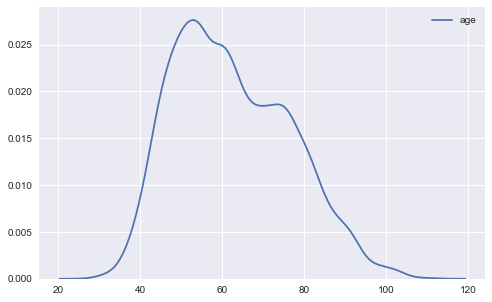

In [17]:
sns.kdeplot(df_train['age'])

## Manufacturing Year

It's not clear how the manufacturing year is coded. Is that really the age of a car? Let's try to find out it. Obviously, for the same combination of the car manufacturer and the model the insurance value should be larger for newer cars. Alas, there is no information on the model...

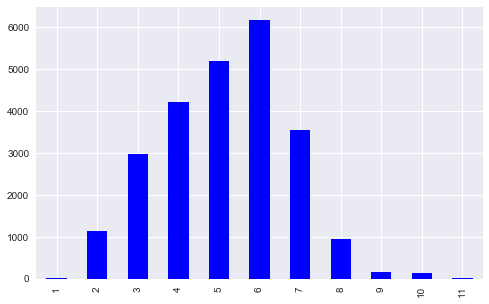

In [18]:
df_train['my'].value_counts().sort_index().plot(kind='bar', color='b')

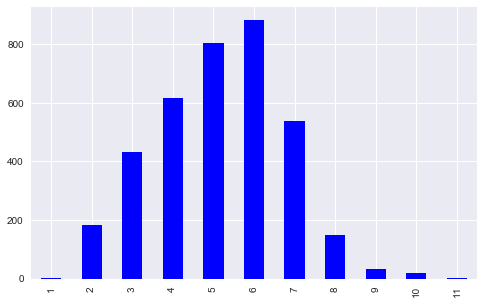

In [19]:
df_test['my'].value_counts().sort_index().plot(kind='bar', color='b')

If that's the manufacturing year, say 20XX, then there is not a lot of new cars which seems to be unusual. If that's the age of a car, then, again, there is a shortage of new cars. Probably, the data has been sampled for a subset of the population?

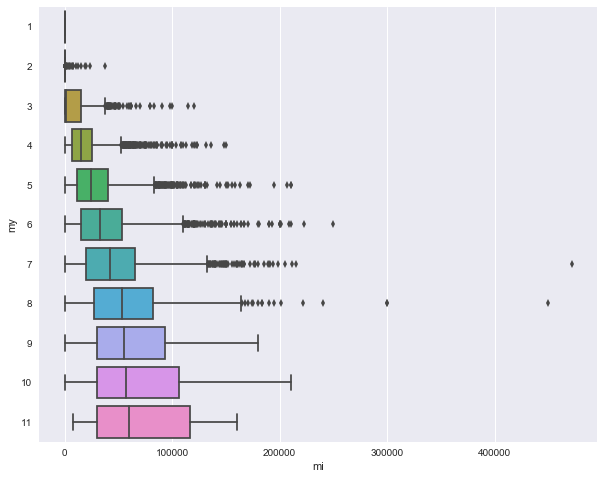

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

p = sns.boxplot(data=df_train, x='mi', y='my', orient='h', ax=ax)

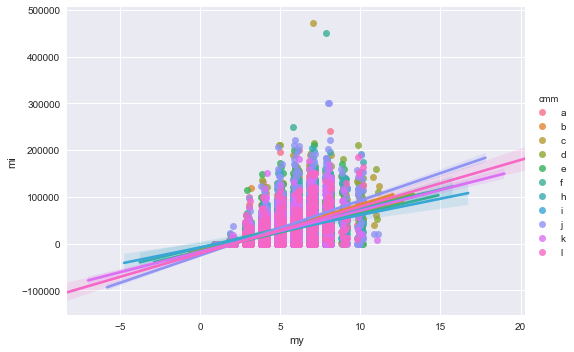

In [67]:
#fig, ax = plt.subplots(figsize=(8, 5))
g = sns.lmplot(x='my', y='mi', data=df_train, hue='cmm', height=5, aspect=1.5, x_jitter=0.2, y_jitter=0.2)

## Mileage

In [21]:
df_train[df_train['mi'] > df_train['mi'].quantile(0.99)].sort_values('mi', ascending=False)

,sex,age,ms,de,drc,crc,tic,cic,overdue_max,cmm,co,my,vt,et,hp,mi,bb,tp,target
662,2,46.44,a1,16.49,b0,b0,10,1,14.00,c,c1,7,1,q1,140.00,"472,000.00",0,5.60,"275,115.48"
16960,2,68.07,a1,39.85,b0,b0,13,0,44.00,f,c4,8,1,q1,211.00,"450,000.00",0,5.83,"913,164.51"
2928,1,73.01,a1,22.13,b78,b78,30,0,30.00,j,c3,8,1,q2,235.00,"300,000.00",0,1.21,"1,112,671.64"
4291,1,60.56,a1,29.06,b0,b0,27,0,6.38,j,c3,8,1,q1,288.00,"300,000.00",1,7.01,"1,231,893.17"
19785,1,75.47,a3,19.32,b0,b0,6,1,0.00,f,c1,6,1,q1,211.00,"250,000.00",0,1.15,"1,042,879.05"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22165,2,64.33,a1,38.52,b0,b0,57,4,0.00,j,c3,8,1,q2,173.00,"131,000.00",1,4.57,"1,088,194.77"
3875,2,59.29,a1,29.06,b57,b57,36,2,4.00,k,c4,6,1,q2,245.00,"130,750.00",0,3.69,"1,319,337.75"
22643,2,49.04,a1,20.73,b568,b568,5,2,0.00,k,c4,7,1,q1,238.00,"130,600.00",0,2.08,"1,075,566.73"
18115,2,56.75,a2,24.92,b97,b96,1,0,33.00,f,c1,6,1,q2,170.00,"130,483.00",0,5.88,"901,837.63"


Ok, the mileage looks sensible in spite of the high values.

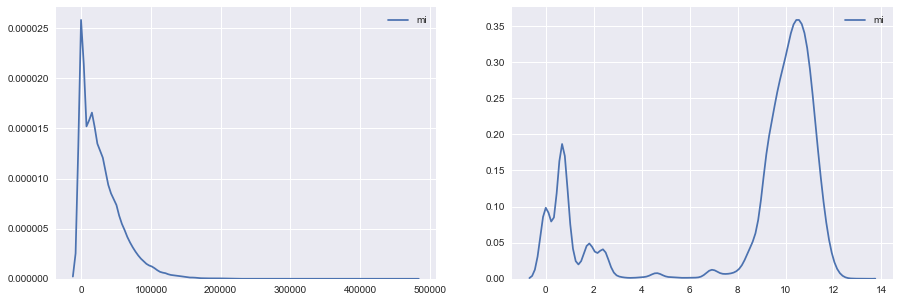

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = axs[0]
p = sns.kdeplot(df_train['mi'], ax=ax)

ax = axs[1]
p = sns.kdeplot(np.log(df_train['mi'] + 1), ax=ax)

In [35]:
df_train[df_train['mi'] > 100000]['my'].value_counts().sort_values()

3       2
11      4
4      14
9      34
10     36
5      60
8     140
6     187
7     270
Name: my, dtype: int64

In [33]:
df_train[df_train['mi'] < 5000]['my'].value_counts().sort_values()

1        6
10      10
9       10
8      115
7      551
5      823
4      858
6     1002
2     1116
3     1569
Name: my, dtype: int64

In [23]:
df_train['mi_norm'] = np.log(df_train['mi'] + 1)
df_test['mi_norm']  = np.log(df_test['mi'] + 1)

## Horse Power

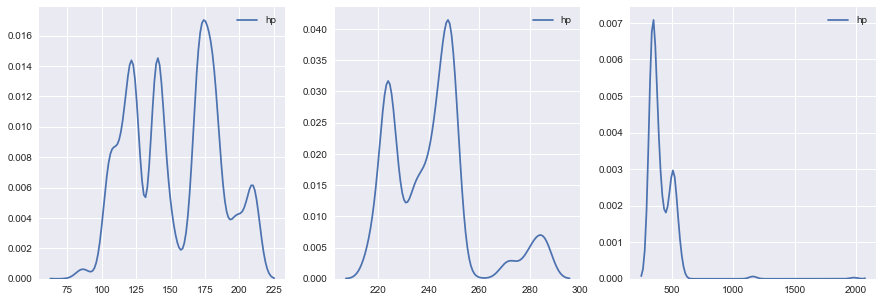

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax = axs[0]
p = sns.kdeplot(df_train[df_train['hp'] <= df_train['hp'].quantile(0.75)]['hp'], ax=ax)

ax = axs[1]
p = sns.kdeplot(df_train[(df_train['hp'] >  df_train['hp'].quantile(0.75)) & 
                         (df_train['hp'] <= df_train['hp'].quantile(0.95))]['hp'], ax=ax)

ax = axs[2]
p = sns.kdeplot(df_train[df_train['hp'] >= df_train['hp'].quantile(0.99)]['hp'], ax=ax)

There are some extreme values, there are very few cars with the horse power over 500, let's check their insured value.

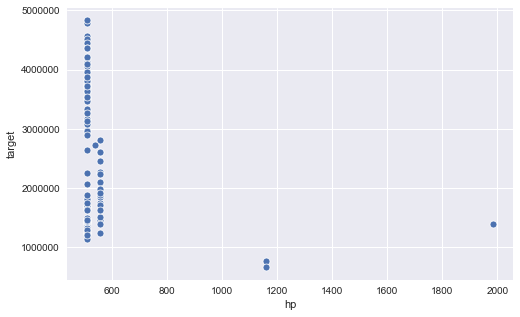

In [19]:
sns.scatterplot(data=df_train[df_train['hp'] >= 500], x='hp', y='target')

Ok, those over 1000 seems to be the input error, correcting them with the '10' divisor.

In [88]:
def normalize_hp(hp):
    if hp >= 1000:
        return(hp/10)
    else:
        return(hp)
    
df_train['hp'] = df_train['hp'].apply(lambda x: normalize_hp(x))
df_test['hp']  = df_test['hp'].apply(lambda x: normalize_hp(x))

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


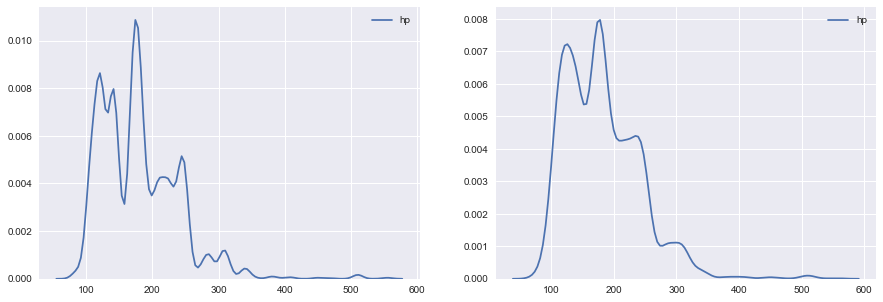

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = axs[0]
p = sns.kdeplot(df_train['hp'], ax=ax)

ax = axs[1]
p = sns.kdeplot(df_test['hp'], ax=ax)

The distribution of hp is multimodal. We can try to derive the model car by clustering on cmm, the range of hp and the country of origin.

In [123]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')

est.fit(df_train[['hp']])

print(est.bin_edges_)

df_train['hp_class'] = est.transform(df_train[['hp']])
df_train['hp_class'] = df_train['hp_class'].astype('int')
df_test['hp_class']  = est.transform(df_test[['hp']])
df_test['hp_class']  = df_test['hp_class'].astype('int')

[array([ 77., 123., 140., 170., 181., 209., 243., 555.])]


In [124]:
# correcting the data type for categorical data
for col_name in ['hp_class']:
    df_train[col_name] = df_train[col_name].astype('category')
    df_test[col_name]  = df_test[col_name].astype('category')
    # copying the full set of categories as this will be required by pasty later
    df_test[col_name]  = df_test[col_name].cat.set_categories(df_train[col_name].cat.categories)

In [125]:
df_train

,sex,age,ms,de,drc,crc,tic,cic,overdue_max,cmm,...,vt,et,hp,mi,bb,tp,target,mi_norm,hp_class,target_bx
0,2,58.03,a1,15.07,b0,b0,23,1,53.00,k,...,1,q2,249.00,1.00,1,3.10,"3,105,287.61",0.69,6,3.70
1,1,81.55,a3,12.20,b0,b0,4,3,6.00,a,...,1,q1,123.00,"2,100.00",0,1.67,"375,255.68",7.65,1,3.65
2,2,76.69,a1,50.34,b4,b4,9,0,10.16,j,...,1,q1,181.00,1.00,1,4.27,"991,012.34",0.69,4,3.68
3,1,79.13,a1,20.73,b86,b0,29,0,0.00,f,...,1,q2,211.00,"60,000.00",0,5.20,"938,984.99",11.00,5,3.68
4,2,81.55,a1,51.63,b0,b0,19,0,37.00,h,...,1,q1,209.00,"48,065.00",0,6.14,"776,107.46",10.78,5,3.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24506,1,65.58,a1,26.31,b0,b0,17,3,46.00,d,...,1,q1,141.00,"41,300.00",0,5.60,"486,526.26",10.63,2,3.66
24507,2,76.69,a1,24.92,b0,b0,17,2,4.00,f,...,1,q1,224.00,"24,100.00",0,6.30,"1,223,845.16",10.09,5,3.68
24508,2,54.20,a3,17.91,b0,b0,6,2,0.00,d,...,1,q1,141.00,"22,000.00",0,2.79,"495,163.39",10.00,2,3.66
24509,2,55.48,a1,20.73,b1830,b1830,19,0,51.00,j,...,1,q1,281.00,"61,988.00",0,5.92,"1,083,848.60",11.03,6,3.68


## Driving Experience

There are missing values for the driving experience. 

The driving experience is missed for 86 drivers mostly under the age of 53 which is worrying because it's the age in the 25% percentile. Simply excluding these rows from the dataset may affect the quality of the model esp. given the test data contains the cases for this range of ages (under 53).

The distribution of data without the missing values is pretty much the same as with it. The major difference is there are some cities which are presented only for the cases with the missing date. It might be critical for building a good model covering those specific locations as well.

Without the missing data

In [50]:
df_train[~df_train.isnull().any(axis=1)].describe()

,age,de,tic,cic,overdue_max,my,hp,mi,bb,tp,target,mi_norm
count,"24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00","24,425.00"
mean,62.52,23.37,15.07,1.16,26.00,5.16,179.77,"29,184.96",0.09,4.01,"860,473.12",8.15
std,14.18,12.83,14.12,1.63,28.66,1.57,60.97,"30,260.25",0.28,2.04,"620,352.20",3.96
min,27.68,0.00,0.00,0.00,0.00,1.00,77.00,0.00,0.00,-0.59,"231,853.40",0.00
25%,51.63,13.64,6.00,0.00,5.00,4.00,140.00,"5,000.00",0.00,2.24,"435,183.26",8.52
50%,60.56,20.73,11.00,1.00,20.31,5.00,173.00,"21,000.00",0.00,4.02,"678,556.83",9.95
75%,73.01,29.06,20.00,2.00,40.00,6.00,211.00,"44,000.00",0.00,5.78,"1,075,566.73",10.69
max,113.29,82.76,239.00,22.00,824.00,11.00,"1,984.00","472,000.00",1.00,8.66,"4,833,195.20",13.06


In [51]:
df_train[~df_train.isnull().any(axis=1)][['sex', 'drc', 'crc', 'et', 'vt', 'co', 'cmm']].describe()

,sex,drc,crc,et,vt,co,cmm
count,24425,24425,24425,24425,24425,24425,24425
unique,2,817,785,7,1,8,11
top,2,b0,b0,q1,1,c4,e
freq,15583,17635,17713,19491,24425,9333,4977


Comparing that to those with the missing driving experience.

In [52]:
df_train_missing_data.describe()

,age,de,tic,cic,overdue_max,my,hp,mi,bb,tp,target
count,86.00,0.00,86.00,86.00,86.00,86.00,86.00,86.00,86.00,86.00,86.00
mean,47.16,nan,5.35,0.62,33.30,4.15,146.10,"19,044.17",0.05,4.05,"682,531.72"
std,12.23,nan,8.81,1.56,21.99,1.84,51.62,"34,824.14",0.21,2.06,"516,217.49"
min,26.31,nan,0.00,0.00,0.00,2.00,90.00,0.00,0.00,0.11,"274,992.99"
25%,38.52,nan,0.25,0.00,19.25,3.00,110.00,1.00,0.00,2.74,"435,767.23"
50%,45.13,nan,3.00,0.00,31.08,4.00,123.00,5.00,0.00,3.95,"478,203.89"
75%,52.92,nan,7.00,1.00,44.90,6.00,169.25,"18,325.00",0.00,5.45,"694,196.86"
max,79.13,nan,56.00,12.00,103.00,9.00,340.00,"138,000.00",1.00,7.80,"2,940,854.86"


In [53]:
df_train_missing_data[['sex', 'drc', 'crc', 'et', 'vt', 'co', 'cmm']].describe()

,sex,drc,crc,et,vt,co,cmm
count,86,86,86,86,86,86,86
unique,2,26,25,2,1,5,9
top,1,b0,b0,q1,1,c0,b
freq,47,58,57,77,86,30,20


In [54]:
df_test['age'].describe()

count   3,662.00
mean       62.15
std        14.31
min        27.68
25%        50.34
50%        60.56
75%        73.01
max       109.85
Name: age, dtype: float64

For imputting the driving experience, it'd be wise to regress it on the other features.

Looking for any obvious associations

In [55]:
df_train_no_null = df_train[~df_train.isnull().any(axis=1)]

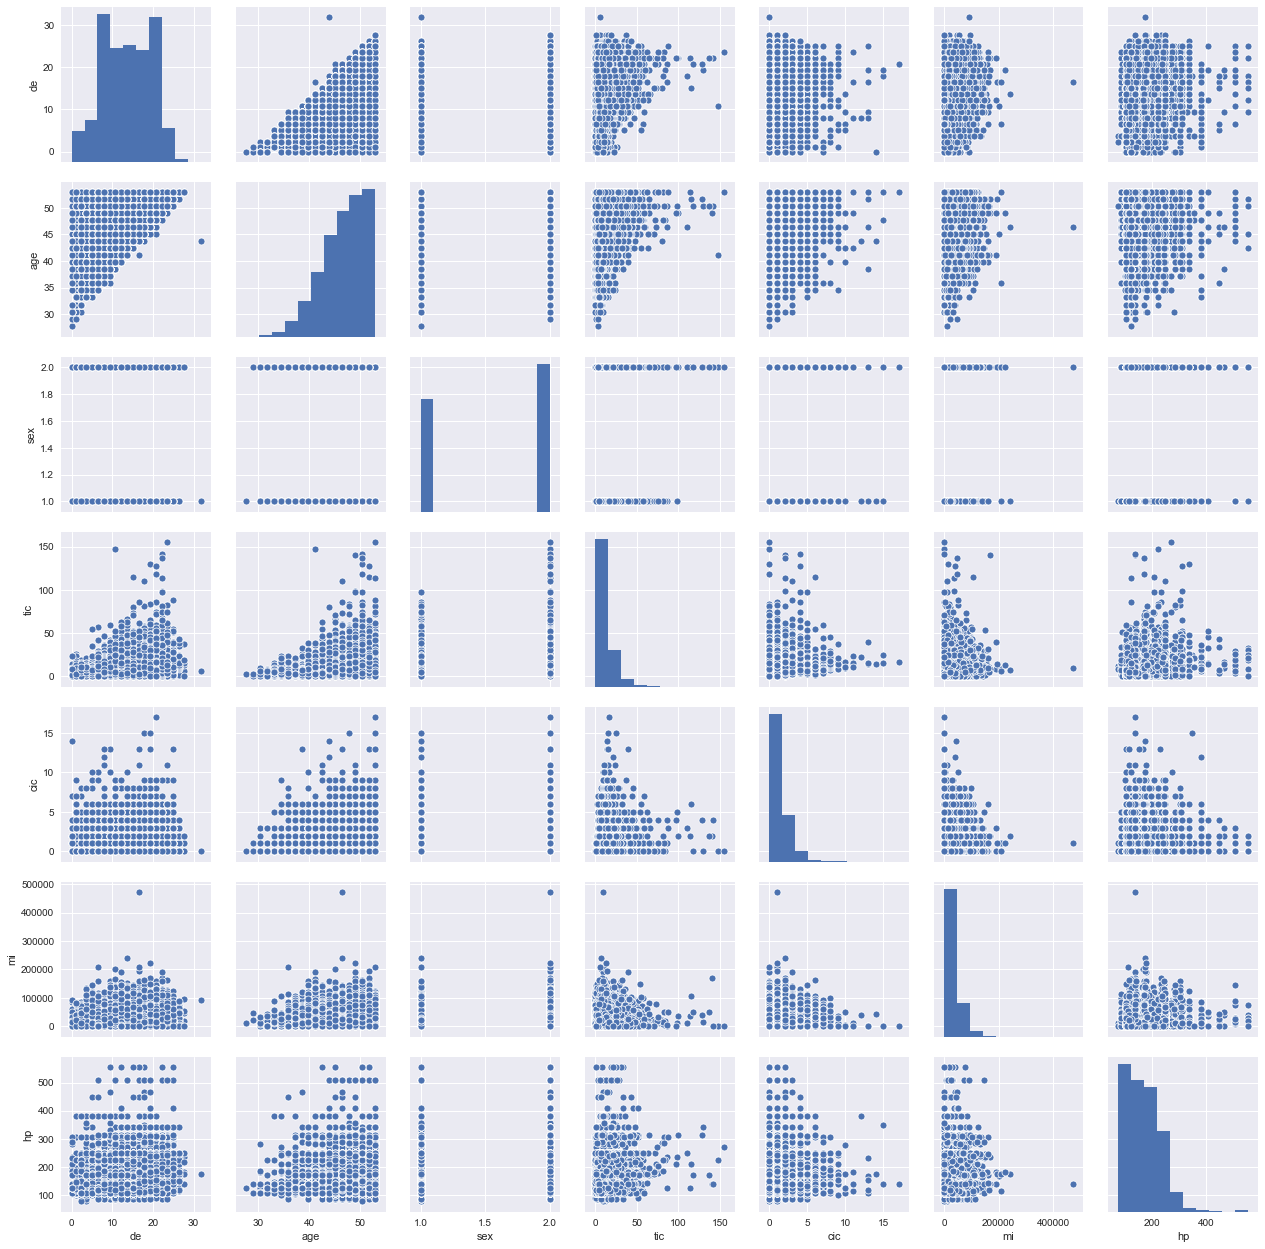

In [56]:
p = sns.pairplot(df_train_no_null[df_train_no_null['age'] <= 53][['de', 'age', 'sex', 'ms', 'tic', 'cic', 'mi', 'hp']])

## Technical Parameter

In [89]:
df_train['tp'].describe()

count   24,511.00
mean         4.01
std          2.04
min         -0.59
25%          2.24
50%          4.02
75%          5.78
max          8.66
Name: tp, dtype: float64

There are negative values, the distribution looks like an uniform one though there are tails.

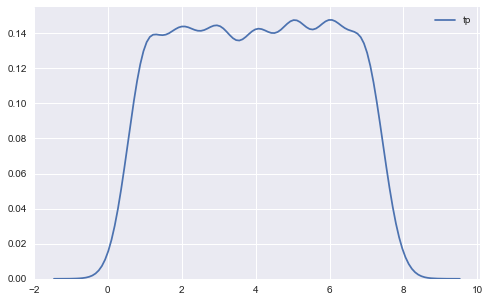

In [90]:
g = sns.kdeplot(df_train['tp'])

## Geo Locations

In [91]:
df_train['drc'].value_counts().sort_values(ascending=False)

b0       17693
b4         306
b3         241
b17        239
b37        239
         ...  
b1300        1
b130         1
b1295        1
b1287        1
b264         1
Name: drc, Length: 822, dtype: int64

In [92]:
df_train['crc'].value_counts().sort_values(ascending=False)

b0       17770
b4         297
b17        250
b3         244
b18        242
         ...  
b1074        1
b1352        1
b837         1
b1081        1
b861         1
Name: crc, Length: 789, dtype: int64

In [93]:
len(df_train[df_train['drc'].astype('str') != df_train['crc'].astype('str')])

764

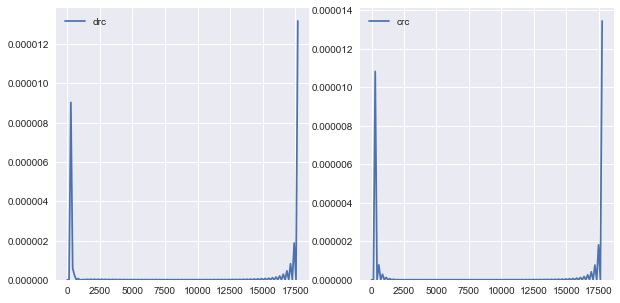

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

p = sns.kdeplot(df_train['drc'].value_counts(), ax=axs[0])
p = sns.kdeplot(df_train['crc'].value_counts(), ax=axs[1])

In [95]:
df_train['rc_differ'] = df_train['drc'].astype('str') != df_train['crc'].astype('str')

In [112]:
# let's break all drc, crc into the ranges to probably reflect if that's a low population region (tend to drive prices low)

## Insured Value

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


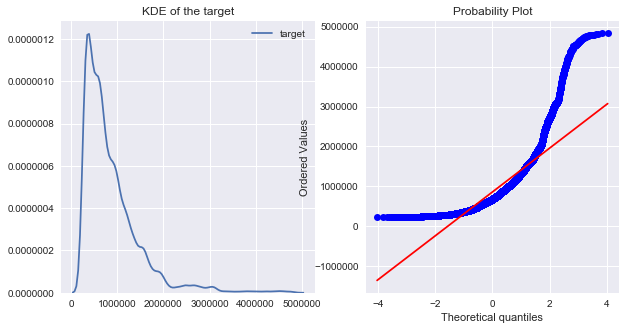

In [113]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

g = sns.kdeplot(df_train['target'], ax=axs[0])
t = axs[0].set_title('KDE of the target')

r = stats.probplot(df_train['target'], plot=axs[1])

The distribution of the insured value is not normal. We may want to transform it for certain models with the log transformation or the Box-Cox one.

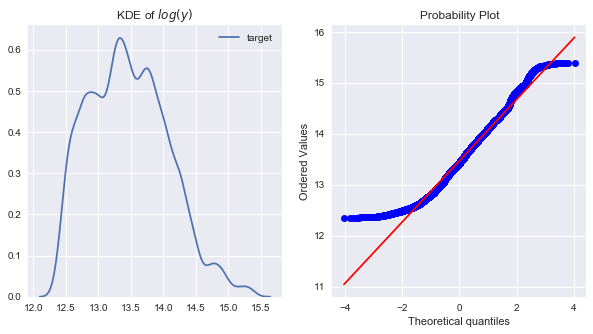

In [114]:
x = np.log(df['target'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

g = sns.kdeplot(x, ax=axs[0])
t = axs[0].set_title('KDE of $log(y)$')

r = stats.probplot(x, plot=axs[1])

That looks better but still not good enough.

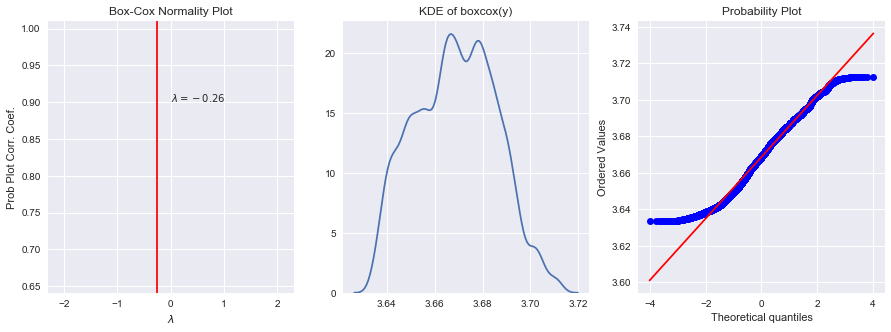

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# be aware of the issue with automatic findind of lambda: https://github.com/scipy/scipy/issues/6873
# this is the reason the lambda coefficient is calculated separetely with boxcox_normmax
lmax = stats.boxcox_normmax(df['target'].values, brack=(-2.1, 2.1),  method='mle')
# sadly, boxcox_normplot does not produce the graph, mostly probable due to the issue above
prob = stats.boxcox_normplot(df['target'].values, -2.1, 2.1, plot=axs[0])
axs[0].axvline(lmax, color='r')
axs[0].annotate('$\lambda=%.2f$' % lmax, (0, 0.9))

x_bx = stats.boxcox(x=df['target'].values, lmbda=lmax)

g = sns.kdeplot(x_bx, ax=axs[1])
t = axs[1].set_title('KDE of boxcox(y)')

# print('lambda: %f, CI: [%f,%f]' % (lmax, ci[0], ci[1]))
r = stats.probplot(x_bx, plot=axs[2])

plt.show()

It looks a bit better than the plain log transformation though the tails are still out of the normality.

In [116]:
df_train['target_bx'] = x_bx

# New Features

## 'Car Class'

The information on the model is not available but we can try to extract it using the clustering approach: per each cmm, using the country of origin, the type of engine and the horse power class.

In [117]:
# TBC

# Saving Pre-Processed Data

In [126]:
df_train.to_csv('insvalue_train.pre-processed.csv', sep='\t')
df_test.to_csv('insvalue_test.pre-processed.csv', sep='\t')

# Loading Pre-Processed Data

In [127]:
df = df_train.copy()

# EDA

## Pairplot

Getting initial impression of the data with the univariate statistics.

In [128]:
df.describe()

,age,de,tic,cic,overdue_max,my,hp,mi,bb,tp,target,mi_norm,target_bx
count,"24,511.00","24,425.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00","24,511.00"
mean,62.46,23.37,15.03,1.16,26.02,5.16,179.49,"29,149.38",0.09,4.01,"859,848.79",8.14,3.67
std,14.20,12.83,14.12,1.63,28.65,1.58,59.21,"30,282.59",0.28,2.04,"620,097.89",3.96,0.02
min,26.31,0.00,0.00,0.00,0.00,1.00,77.00,0.00,0.00,-0.59,"231,853.40",0.00,3.63
25%,51.63,13.64,6.00,0.00,5.00,4.00,140.00,"5,000.00",0.00,2.24,"435,176.37",8.52,3.66
50%,60.56,20.73,11.00,1.00,20.61,5.00,173.00,"21,000.00",0.00,4.02,"678,556.83",9.95,3.67
75%,73.01,29.06,20.00,2.00,40.00,6.00,211.00,"44,000.00",0.00,5.78,"1,075,319.86",10.69,3.68
max,113.29,82.76,239.00,22.00,824.00,11.00,555.00,"472,000.00",1.00,8.66,"4,833,195.20",13.06,3.71


In [130]:
df[['sex', 'drc', 'crc', 'vt', 'et', 'cmm', 'co', 'hp_class']].describe()

,sex,drc,crc,vt,et,cmm,co,hp_class
count,24511,24511,24511,24511,24511,24511,24511,24511
unique,2,822,789,1,7,11,8,7
top,2,b0,b0,1,q1,e,c4,2
freq,15622,17693,17770,24511,19568,4996,9360,4146


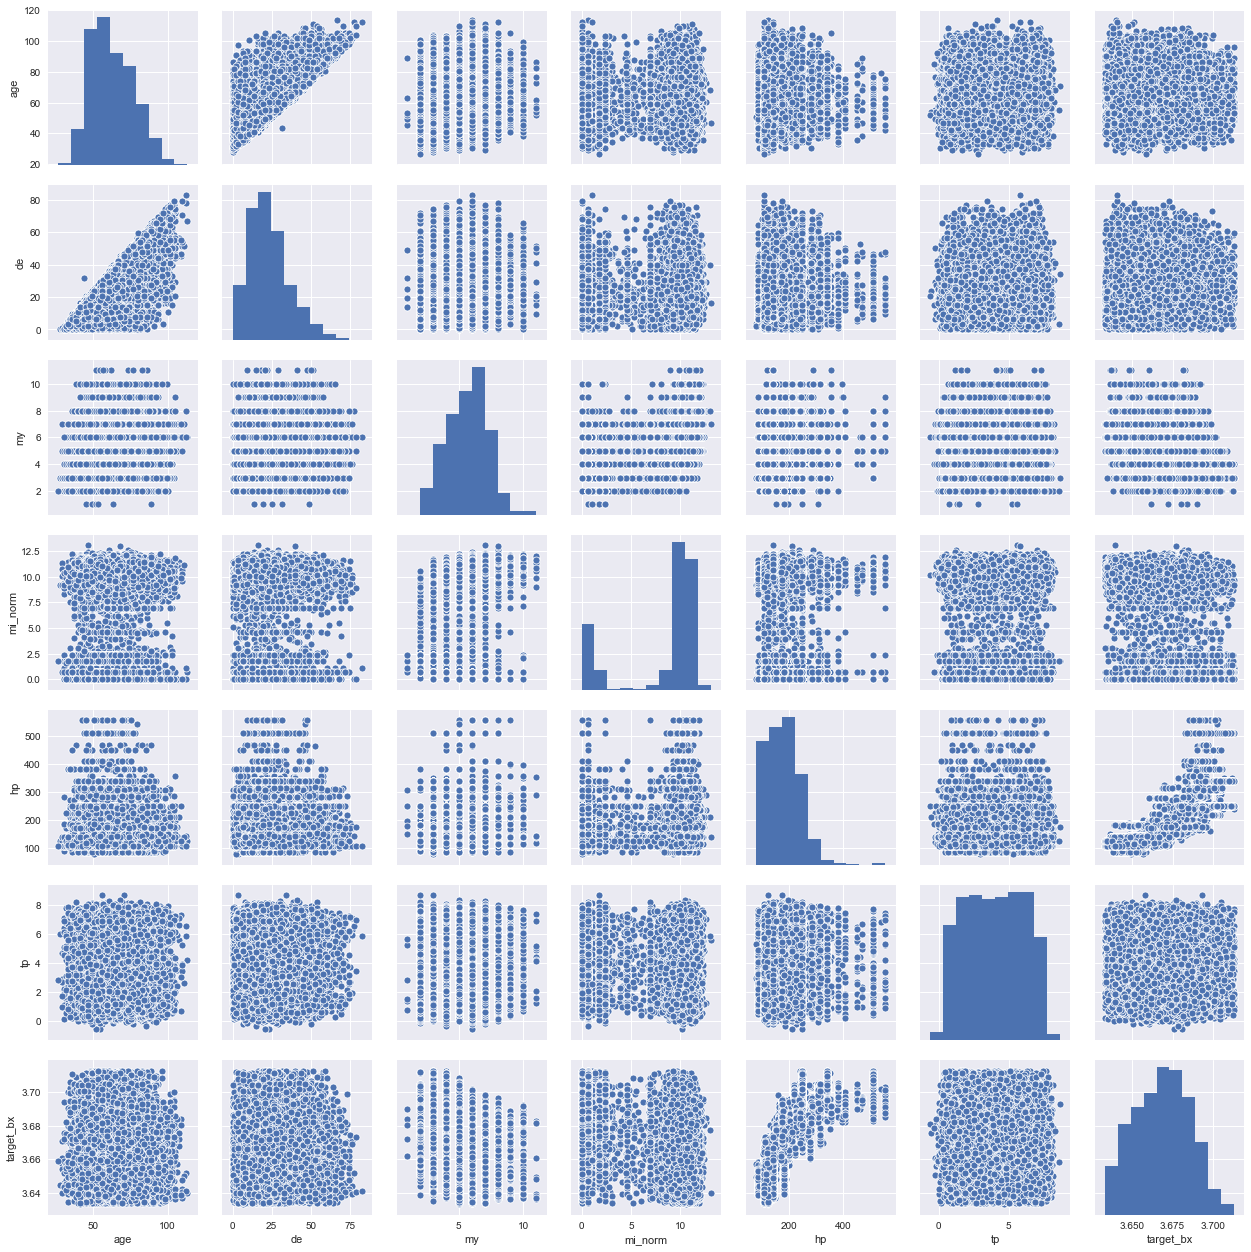

In [154]:
#%matplotlib notebook

g = sns.pairplot(data=df, vars=['age', 'de', 'my', 'mi_norm', 'hp', 'tp', 'target_bx']) #, height=7, aspect=1)
#g.fig.set_rasterized(True)

A lot of clouds difficult to find good associations within.

## Conclusions

Some interesting observations following EDA:
    
- most of clients are above the age of 50,
- the data missing only for the driving experience and, mostly, for drivers under the age of 50,
- clients are distributed across cities non-uniformly
- veehicle type can be excluded as it's a constant

# Models

## M1 - RF

In [145]:
df_test_m1 = pd.read_csv('insvalue_predict2.csv', index_col='id')

In [187]:
df_test_m1_2 = pd.read_csv('insvalue_predict3.csv', skiprows=2)
df_test_m1_2.columns = ['target', 'id']
df_test_m1_2['id'] = df_test_m1_2['id'].astype('int')
df_test_m1_2 = df_test_m1_2.set_index('id')
df_test_m1_2['target'] = round(df_test_m1_2['target'], 2)

In [188]:
df_test_m1_2.to_csv('insvalue_predict3_to_upload.csv', sep=',')

In [190]:
! kaggle competitions submit -c finunichamp2018-1 -f insvalue_predict3_to_upload.csv -m "Model M1"

Successfully submitted to Оценка страховой стоимости транспортного средства



  0%|          | 0.00/56.8k [00:00<?, ?B/s]
100%|##########| 56.8k/56.8k [00:05<00:00, 11.6kB/s]


## M2 - GLM

In [132]:
df_no_null = df[~df.isnull().any(axis=1)]

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24511 entries, 0 to 24510
Data columns (total 22 columns):
sex            24511 non-null category
age            24511 non-null float64
ms             24511 non-null category
de             24425 non-null float64
drc            24511 non-null category
crc            24511 non-null category
tic            24511 non-null int64
cic            24511 non-null int64
overdue_max    24511 non-null float64
cmm            24511 non-null category
co             24511 non-null category
my             24511 non-null int64
vt             24511 non-null category
et             24511 non-null category
hp             24511 non-null float64
mi             24511 non-null float64
bb             24511 non-null int64
tp             24511 non-null float64
target         24511 non-null float64
mi_norm        24511 non-null float64
hp_class       24511 non-null category
target_bx      24511 non-null float64
dtypes: category(9), float64(9), int64(4)
memory usage

In [179]:
# df['exog'] = sm.add_constant(data.exog)

#res = sm.formula.glm("target ~ sex + age + ms + de + cmm + co + my + et + hp_class + mi + bb + tp",  
#                     family=sm.families.Gamma(sm.families.links.log), 
#                     data=df_no_null).fit() 

res = sm.formula.glm("target_bx ~ sex + age + ms + de + cmm + co + my + et + hp_class + mi + bb + tp",  
                     family=sm.families.Gamma(sm.families.links.identity), 
                     data=df_no_null).fit() 

res.summary()

c:\python37\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:302: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              target_bx   No. Observations:                24425
Model:                            GLM   Df Residuals:                    24382
Model Family:                   Gamma   Df Model:                           42
Link Function:               identity   Scale:                      2.2851e-06
Method:                          IRLS   Log-Likelihood:                 92247.
Date:                Thu, 17 Jan 2019   Deviance:                     0.055701
Time:                        03:20:00   Pearson chi2:                   0.0557
No. Iterations:                     6   Covariance Type:             nonrobust
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6642      0.000    1.3e+04      0.000       3.664       3.665
sex[T.2]          0.0004    8.4e-05      5.222      0.000       0.000       0.001
ms[T.a2]         -0.0002      0.000     -1.081      0.280      -0.001       0.000
ms[T.a3]         -0.0002   9.79e-05     -2.532      0.011      -0.000    -5.6e-05
ms[T.a4]          0.0004      0.001      0.815      0.415      -0.001       0.001
ms[T.a5]         -0.0006      0.001     -0.735      0.463      -0.002       0.001
ms[T.a6]         -0.0025      0.001     -2.426      0.015      -0.005      -0.000
ms[T.a7]         -0.0004      0.002     -0.235      0.814      -0.004       0.003
cmm[T.b]          0.0017      0.000     10.226      0.000       0.001       0.002
cmm[T.c]         -0.0025      0.000    -10.688      0.000      -0.003      -0.002
cmm[T.d]          0.0050      0.000     18.222      0.000       0.004       0.006
cmm[T.e]          0.0024      0.000     10.949      0.000       0.002       0.003
cmm[T.f]          0.0089      0.000     37.185      0.000       0.008       0.009
cmm[T.h]          0.0049      0.000     11.324      0.000       0.004       0.006
cmm[T.i]          0.0070      0.000     14.704      0.000       0.006       0.008
cmm[T.j]          0.0072      0.000     26.231      0.000       0.007       0.008
cmm[T.k]          0.0075      0.000     29.093      0.000       0.007       0.008
cmm[T.l]          0.0124      0.000     25.201      0.000       0.011       0.013
co[T.c1]         -0.0009      0.000     -5.028      0.000      -0.001      -0.001
co[T.c10]        -0.0006      0.001     -1.077      0.281      -0.002       0.000
co[T.c3]         -0.0011      0.000     -4.033      0.000      -0.002      -0.001
co[T.c4]         -0.0010      0.000     -4.481      0.000      -0.001      -0.001
co[T.c5]         -0.0056      0.002     -2.469      0.014      -0.010      -0.001
co[T.c7]         -0.0010      0.001     -1.867      0.062      -0.002       5e-05
co[T.c8]         -0.0007      0.000     -1.464      0.143      -0.002       0.000
et[T.q2]          0.0071      0.000     71.355      0.000       0.007       0.007
et[T.q3]          0.0115      0.006      2.067      0.039       0.001       0.022
et[T.q4]          0.0026      0.006      0.476      0.634      -0.008       0.013
et[T.q5]         -0.0007      0.002     -0.312      0.755      -0.005       0.004
et[T.q6]          0.0078      0.003      2.422      0.015       0.001       0.014
et[T.q7]          0.0004      0.006      0.075      0.940      -0.010       0.011
hp_class[T.1]    -0.0023      0.000    -12.873      0.000      -0.003      -0.002
hp_class[T.2]     0.0103      0.000     74.973      0.000       0.010       0.011
hp_class[T.3]     0.0199      0.000    142.860      0.000       0.020       0.020
hp_class[T.4]     0.0173      0.000    108.375      0.000       0.017       0.018
hp_class[T.5]     0.0270      0.000    156.294

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


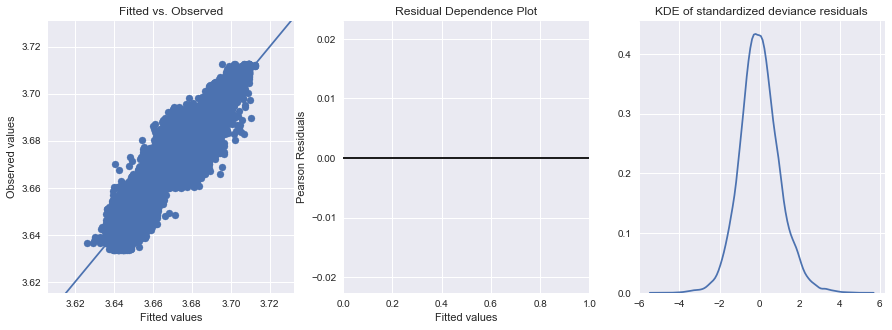

In [184]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# fitted vs. observed
y = df_no_null['target_bx'].values

yhat = res.mu

from statsmodels.graphics.api import abline_plot

ax = axs[0]
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_title('Fitted vs. Observed')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');


# Residual Dependence Plot
ax = axs[1]
ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')


# Histogram of standardized deviance residuals:
resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax = axs[2]
p = sns.kdeplot(resid_std, ax=ax)
#ax.hist(resid_std, bins=25)
ax.set_title('KDE of standardized deviance residuals');

In [161]:
# prediction

In [162]:
# dirty fix - filling in the missing values for the test set
df_test['de'] = df_test['de'].fillna(df[df['age'] < 50]['de'].median())

In [163]:
# even more dirty fix
df_test['mi'] = df_test['mi'].fillna(20000)

In [164]:
df_test['target_bx'] = res.predict(df_test, transform=True)

In [142]:
df_test['target'] = res.predict(df_test, transform=True)

In [165]:
df_test['target'] = np.round(scipy.special.inv_boxcox(df_test['target_bx'].values, lmax), 2)

In [166]:
df_test['target'] = df_test['target'].fillna(df_test['target'].max())

In [167]:
# checking there are no null's for the target
df_test[df_test['target'].isnull()]

,sex,age,ms,de,drc,crc,tic,cic,overdue_max,cmm,...,vt,et,hp,mi,bb,tp,target,mi_norm,hp_class,target_bx
id,,,,,,,,,,,,,,,,,,,,,


In [168]:
df_test.head(5)

,sex,age,ms,de,drc,crc,tic,cic,overdue_max,cmm,...,vt,et,hp,mi,bb,tp,target,mi_norm,hp_class,target_bx
id,,,,,,,,,,,,,,,,,,,,,
1,1,74.24,a1,35.84,b0,b0,31,6,7.00,k,...,1,q1,184.00,"17,001.00",0,1.47,"681,082.32",9.74,4,3.67
2,2,86.36,a1,59.29,b0,b0,24,0,0.00,h,...,1,q1,209.00,"54,000.00",0,4.06,"999,319.46",10.90,5,3.68
3,2,69.31,a1,24.92,b0,b0,4,0,36.00,h,...,1,q1,209.44,"48,123.00",0,0.43,"721,493.46",10.78,5,3.67
4,1,56.75,a3,10.76,b0,b0,13,5,37.00,k,...,1,q1,245.00,"35,000.00",1,4.08,"1,198,967.34",10.46,6,3.68
5,2,71.78,a1,23.53,b42,b42,3,1,2.00,e,...,1,q1,170.00,"33,872.00",0,5.80,"632,334.36",10.43,3,3.67


In [169]:
df_test[['target']].to_csv('insvalue_test_predicted.csv', sep=',')

In [ ]:
# Uploading to Kaggle

In [172]:
#! kaggle competitions submit -c finunichamp2018-1 -f .\insvalue_test_predicted.csv -m "GLM"

Successfully submitted to Оценка страховой стоимости транспортного средства



  0%|          | 0.00/56.9k [00:00<?, ?B/s]
100%|##########| 56.9k/56.9k [00:04<00:00, 13.1kB/s]


In [170]:
df_test_m2 = df_test

# Model Comparision

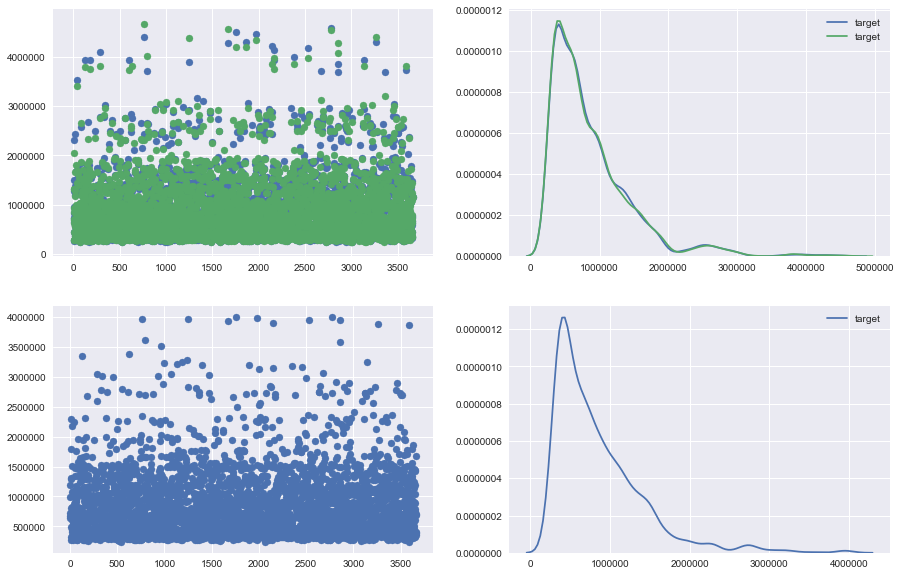

In [189]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax = axs[0][0]
ax.scatter(x='id', y='target', data=df_test_m1.reset_index())
ax.scatter(x='id', y='target', data=df_test_m1_2.reset_index())

ax = axs[0][1]
p = sns.kdeplot(df_test_m1['target'], ax=ax)
p = sns.kdeplot(df_test_m1_2['target'], ax=ax)

ax = axs[1][0]
ax.scatter(x='id', y='target', data=df_test_m2.reset_index())

ax = axs[1][1]
p = sns.kdeplot(df_test_m2['target'], ax=ax)

# Ideas
1. Build several models depending on the range of ...